In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### SWS

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.24, Prune Accuracy: 96.51, Sparsity: 97.67
Epoch: 20. Test Accuracy: 97.66, Prune Accuracy: 97.31, Sparsity: 97.68
Epoch: 30. Test Accuracy: 97.68, Prune Accuracy: 97.53, Sparsity: 97.68
Epoch: 40. Test Accuracy: 97.68, Prune Accuracy: 97.62, Sparsity: 97.70
Epoch: 50. Test Accuracy: 97.87, Prune Accuracy: 97.51, Sparsity: 97.75
Retrain Test: 97.87, Prune Test: 97.51, Prune Sparsity: 97.75


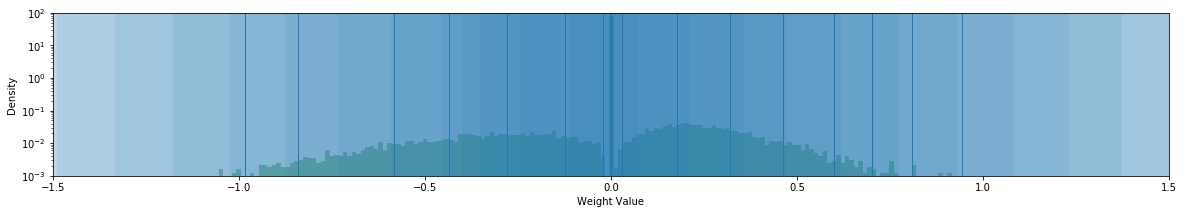

In [3]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.08, Prune Accuracy: 96.31, Sparsity: 97.71
Epoch: 20. Test Accuracy: 97.57, Prune Accuracy: 97.08, Sparsity: 97.72
Epoch: 30. Test Accuracy: 97.75, Prune Accuracy: 97.41, Sparsity: 97.70
Epoch: 40. Test Accuracy: 97.75, Prune Accuracy: 97.57, Sparsity: 97.76
Epoch: 50. Test Accuracy: 97.75, Prune Accuracy: 97.50, Sparsity: 97.78
Retrain Test: 97.75, Prune Test: 97.50, Prune Sparsity: 97.78


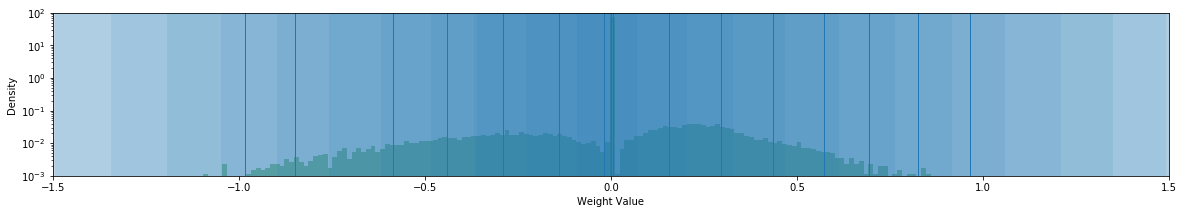

In [4]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', True, "./files")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### SWS + KD

#### CE

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.33, Prune Accuracy: 97.91, Sparsity: 69.46
Epoch: 20. Test Accuracy: 98.01, Prune Accuracy: 95.71, Sparsity: 94.50
Epoch: 30. Test Accuracy: 98.16, Prune Accuracy: 97.04, Sparsity: 96.90
Epoch: 40. Test Accuracy: 98.09, Prune Accuracy: 97.46, Sparsity: 96.90
Epoch: 50. Test Accuracy: 98.03, Prune Accuracy: 97.66, Sparsity: 96.91
Retrain Test: 98.03, Prune Test: 97.66, Prune Sparsity: 96.91


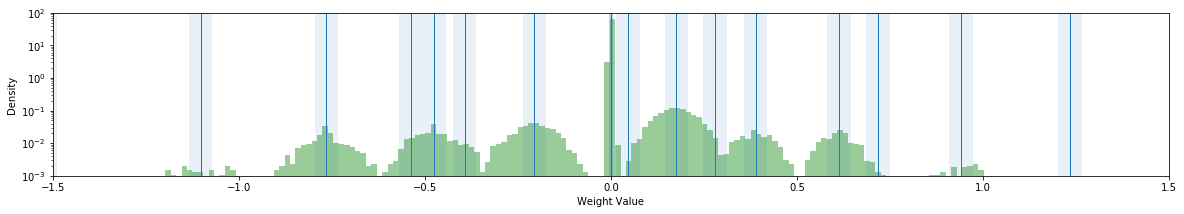

In [6]:
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.39, Prune Accuracy: 91.25, Sparsity: 71.76
Epoch: 20. Test Accuracy: 98.03, Prune Accuracy: 92.80, Sparsity: 97.18
Epoch: 30. Test Accuracy: 97.98, Prune Accuracy: 95.00, Sparsity: 97.35
Epoch: 40. Test Accuracy: 98.14, Prune Accuracy: 95.73, Sparsity: 97.35
Epoch: 50. Test Accuracy: 98.01, Prune Accuracy: 95.96, Sparsity: 97.36
Retrain Test: 98.01, Prune Test: 95.96, Prune Sparsity: 97.36


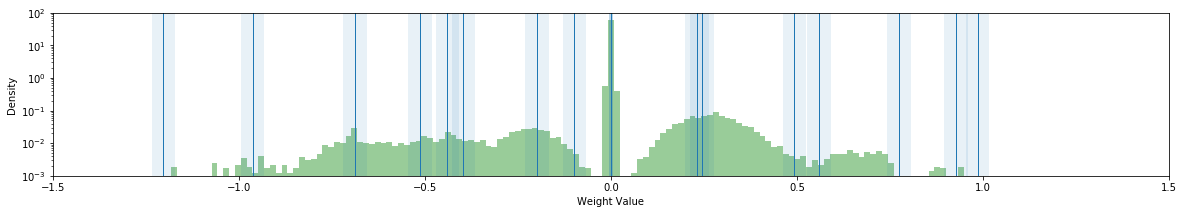

In [7]:
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

#### MSE